In [226]:
import pandas as pd
import re
import unidecode
import demoji
import nltk
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
import spacy
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import tokenize
import nltk

%matplotlib inline

nlp = spacy.load("pt")
nlp.Defaults.stop_words |= {"sábado", "sabado", "quinta", "feira", "terca", "terça", "sexta", "quarta", "segunda", "--", "", " ", "-", "gt", "&gt", "to","uol","mi","budddhetg","the", "ne", "vou", "ta", "via","ex", "pq", "vc","aa","pra","to", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"}

In [227]:
palavras_irrelevantes = set(stopwords.words('portuguese') + list(punctuation) + list(nlp.Defaults.stop_words))

In [228]:
def cleanText(tweet):
    if "|" in tweet:
        tweet = tweet.split("|")[1]
    
    tweet = ' '.join(re.sub(r"http\S+", "", tweet).split())
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([0-9])", " ", tweet).split())
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    tweet = ' '.join(re.sub("[\_\|\.\,\"\'\!\?\-\--\:\;\$\-\(\)\=]", " ", tweet).split())
    tweet = tweet.lower()
    
    le = list(demoji.findall(tweet))
    for i in le:
        tweet = tweet.replace(i, "")
    
    if tweet.startswith('rt '):
        tweet = tweet.replace("rt ", "")
    
    lNewTweet = []
    for i in tweet.split(" "):   
        if i not in palavras_irrelevantes and i not in STOP_WORDS:           
            lNewTweet.append(i)
    
    newTweet = " ".join(lNewTweet)
        
    a = unidecode.unidecode(newTweet.replace(" rt ", "").replace("–", "").replace("--", ""))
    a = a.replace("--", "")
    a = a.replace("\'", "")
    a = a.replace('"', "")
    if "--" in a:
        print("Novamente")
        print(a)
        
    return a

In [229]:
# palavras_irrelevantes

In [230]:
df = pd.read_csv("/opt/documents.csv", sep=";")

In [231]:
df["text_clean"] = df.text.apply(cleanText)
df = df[~df["text"].str.contains("no Google Podcasts")]

In [232]:
# tf_vectorizer.vocabulary_

In [233]:
# token_ = [doc.split(" ") for doc in df["text_clean"].tolist()]
l_text = df["text_clean"].tolist()
l_doc = [nlp(text) for text in l_text]

In [234]:
for i in l_text:
    for j in i:
        
        if j == "-":
            print(i)
            break

In [235]:
token_ = []

In [236]:
for doc in l_doc:
    tokens = [token for token in doc]
    new_doc = []
    for tok in tokens:
        if tok.pos_ == 'VERB':
            new_doc.append(str(tok.lemma_))
        else:
            new_doc.append(str(tok))
    
    token_.append(new_doc)

In [237]:
import gensim
import sys

from gensim.models.phrases import Phraser

bigram = gensim.models.Phrases(token_, min_count=1, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[token_], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [238]:
l = [trigram_mod[bigram_mod[doc]] for doc in token_]

In [239]:
# [(token, token.lemma_) for token in doc if token.pos_ == 'VERB']

In [240]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(l)
corpus = [id2word.doc2bow(text) for text in l]

In [261]:
#alpha: densidade topico-documento
# eta: densidade palavra-topico

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.25,
                                           eta=0.05)

In [290]:
from pprint import pprint# Print the Keyword in the 10 topics
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
# doc_lda = lda_model[corpus]
# print(dir(doc_lda))
# print(doc_lda.corpus)
pprint(lda_model.print_topics())
# pprint(dir(lda_model))
# pprint(lda_model.get_topics().shape)
# print(lda_model.show_topic(2))

# coherencemodel = CoherenceModel(model=lda_model, texts=l, dictionary=id2word, coherence='c_v')
# print(coherencemodel.get_coherence())

[(11,
  '0.027*"henry" + 0.003*"hank" + 0.002*"medidas_adicionais" + '
  '0.002*"excepcionalmente" + 0.002*"loterica_pais_internet" + '
  '0.002*"dispositivos_necessario_cadastro_idade" + '
  '0.002*"site_caixa_economica_federal" + 0.002*" '
  '_acessivel_celular_computador" + 0.002*"apostas_feito_horario_brasilia" + '
  '0.002*"letais"'),
 (6,
  '0.015*"empresa" + 0.012*"plataforma" + 0.009*"usuarios" + 0.009*"twitter" + '
  '0.006*"facebook" + 0.006*"dizer" + 0.005*"conteudo" + 0.005*"companhia" + '
  '0.005*"plataformas" + 0.005*"americanas"'),
 (9,
  '0.042*"monark" + 0.024*"nazismo" + 0.019*"nazista" + '
  '0.016*"apologia_nazismo" + 0.010*"flow_podcast" + 0.009*"discurso_odio" + '
  '0.007*"kataguiri" + 0.005*"estacionar" + 0.005*"kim_kataguiri_dem_sp" + '
  '0.005*"bebado"'),
 (15,
  '0.016*"doenca" + 0.012*"registrar" + 0.012*"brasil" + '
  '0.009*"mortes_ultimos_dias" + 0.009*"covid" + 0.007*"dia" + 0.007*"pais" + '
  '0.007*"mortes_covid" + 0.007*"horas" + 0.006*"casos"'),
 (

0.4314842557920715, 0.43431967020317397, 0.43470914056968535, 0.43636517465862623, 0.47908497549481993


In [265]:
lt = []
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    lt.append(row[0][0])

# print(lt)
contents = pd.Series(lt, name="topic")
data_new = pd.concat([df, contents], axis=1)

In [268]:
for i in data_new[data_new["topic"] == 2].head(10).text_clean.tolist():
    print(i)
    print("\n")
# data_new.topic.value_counts()

sabor intenso caracteristico apreciado amantes fermentacao caseira alimentacao saudavel kombucha cha popular especialistas ouvidos ressaltam ciencia debate populares beneficios bebida ingredientes fundamentais considerado quase incognita movimenta mercado milhoes reais brasil associacao brasileira kombucha abkom reportagem entenda topicos bebida kombucha cha sabor amargo produzido fermentacao processo quimico provocado microrganismos crescem ausencia ar associacao bacterias leveduras agrupado chamado scoby ingles symbiotic culture of bacteria and yeast resultado fermentacao acucar cha geralmente preto verde liquido producao anterior scoby alimenta acucar longo dias dando aspecto gaseificado sabor agridoce caracteristico bebida especialistas sugerem cha imortalidade surgiu meados seculo iii origem incerta fato bebida sabor intenso associada diversos beneficios debate ciencia cultuado supostos efeitos estudiosos tema sugerem longo seculo xx cha ganhou popularidade paises europa devido pr

100%|██████████| 14/14 [01:58<00:00,  8.44s/it]


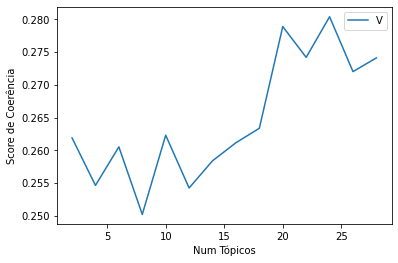

A quantidade de tópicos = 2  tem um valor de coerência de  0.2619
A quantidade de tópicos = 4  tem um valor de coerência de  0.2547
A quantidade de tópicos = 6  tem um valor de coerência de  0.2605
A quantidade de tópicos = 8  tem um valor de coerência de  0.2502
A quantidade de tópicos = 10  tem um valor de coerência de  0.2623
A quantidade de tópicos = 12  tem um valor de coerência de  0.2543
A quantidade de tópicos = 14  tem um valor de coerência de  0.2584
A quantidade de tópicos = 16  tem um valor de coerência de  0.2612
A quantidade de tópicos = 18  tem um valor de coerência de  0.2634
A quantidade de tópicos = 20  tem um valor de coerência de  0.2789
A quantidade de tópicos = 22  tem um valor de coerência de  0.2742
A quantidade de tópicos = 24  tem um valor de coerência de  0.2804
A quantidade de tópicos = 26  tem um valor de coerência de  0.272
A quantidade de tópicos = 28  tem um valor de coerência de  0.2741


In [250]:
from tqdm import tqdm
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        
        model = gensim.models.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values# Colocando parametros na função
    

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=l, start=2, limit=30, step=2)
# Mostrando visualmente a quantidade de tópicos
limit=30; start=2; step=2;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

In [ ]:
data_new.topic.unique()


In [ ]:
for i in data_new[data_new["topic"] == 7].head().text.tolist():
    print(i)
    print("\n")

In [ ]:
import pyLDAvis.gensim
import pickle 
import os
import pyLDAvis# Visualize the topics
num_topics = 28
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
    
LDAvis_prepared